In [1]:
from collections import defaultdict
import os
import sys
sys.path.append('..')

import pandas as pd
from tqdm import tqdm
import torch
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BasicIterator
from allennlp.nn.util import move_to_device

from adat.utils import load_weights, calculate_wer
from adat.models import get_basic_classification_model, get_basic_seq2seq_model
from adat.dataset import InsuranceReader, OneLangSeq2SeqReader

In [2]:
! nvidia-smi

Tue Jan 14 23:24:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 24%   56C    P2    59W / 280W |   1934MiB / 11178MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   32C    P8     9W / 280W |  10283MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
max_length = 12
min_length = 2

data = pd.read_csv('../data/full.csv')

data = data[['treatments', 'target']]
treatment_len = data.treatments.apply(lambda x: len(x.split()))
data = data[(treatment_len <= max_length) & (treatment_len >= min_length)]

In [4]:
data['seq_len'] = data.treatments.apply(lambda x: len(x.split()))

negative = data[data.target == 0]
positive = data[data.target == 1]

In [5]:
negative_examples = defaultdict(list)
positive_examples = defaultdict(list)

for row in negative.itertuples():
    negative_examples[row.seq_len].append(row.treatments.strip())
    
for row in positive.itertuples():
    positive_examples[row.seq_len].append(row.treatments.strip())

# Models

In [6]:
seq2seq_reader = OneLangSeq2SeqReader(masker=None)
seq2seq_vocab = Vocabulary.from_files('vocab_seq2seq_masked2')
seq2seq_model = get_basic_seq2seq_model(seq2seq_vocab)
load_weights(seq2seq_model, 'model_seq2seq_masked2.th')

In [7]:
class_reader = InsuranceReader()
class_vocab = Vocabulary.from_files('vocab_classification2')
class_model = get_basic_classification_model(class_vocab)
load_weights(class_model, 'model_classification2.th')

## MCMC search

In [8]:
from tqdm import tqdm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from adat.mcmc import MCMCSampler, NormalProposal

In [9]:
mcmc_sampler = MCMCSampler(
    proposal_distribution=NormalProposal(0.01), 
    classification_model=class_model, 
    classification_reader=class_reader, 
    generation_model=seq2seq_model, 
    generation_reader=seq2seq_reader,
    sigma_prob=1.0,
    sigma_bleu=2.0,
    device=3
)

In [17]:
num_steps = 200

output = []
for seq_len, examples in positive_examples.items():
    for example in tqdm(examples):
        mcmc_sampler.set_input(example)
        generated_seq = mcmc_sampler.sample_until_satisfied(max_steps=num_steps)
        if generated_seq is not None:
            ex = mcmc_sampler.history[-1]
        else:
            ex = {
                'generated_sequence': 'None',
                'prob': 1.0,
                'bleu': 0.0,
                'prob_diff': 0.0,
                'prob_drop': 0.0,
                'bleu_diff': -1.0,
                'bleu_drop': np.inf,
                'acceptance_probability': 0.0
            }
        
        ex['seq_len'] = seq_len
        ex['original'] = example
        output.append(ex)
        mcmc_sampler.empty_history()
mcmc_output = pd.DataFrame(output)

 14%|█▍        | 48/338 [01:09<07:08,  1.48s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 15%|█▌        | 52/338 [01:14<05:36,  1.18s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower orde

 22%|██▏       | 75/338 [01:51<08:11,  1.87s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 25%|██▍       | 84/338 [02:07<07:36,  1.80s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

 59%|█████▉    | 199/338 [05:04<04:08,  1.79s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 61%|██████    | 207/338 [05:13<02:36,  1.19s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower or

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 67%|██████▋   | 225/338 [05:39<02:52,  1.52s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram orde

 88%|████████▊ | 298/338 [07:28<01:05,  1.64s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram orde

KeyboardInterrupt: 

In [18]:
mcmc_output = pd.DataFrame(output)

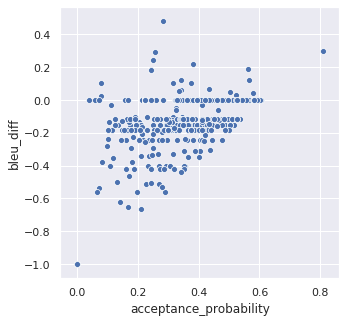

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="acceptance_probability", y="bleu_diff", data=mcmc_output, ax=ax)

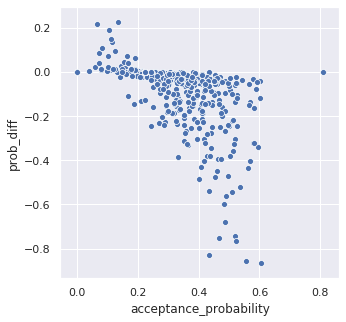

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="acceptance_probability", y="prob_diff", data=mcmc_output, ax=ax)

AttributeError: 'DataFrame' object has no attribute 'seq_len'

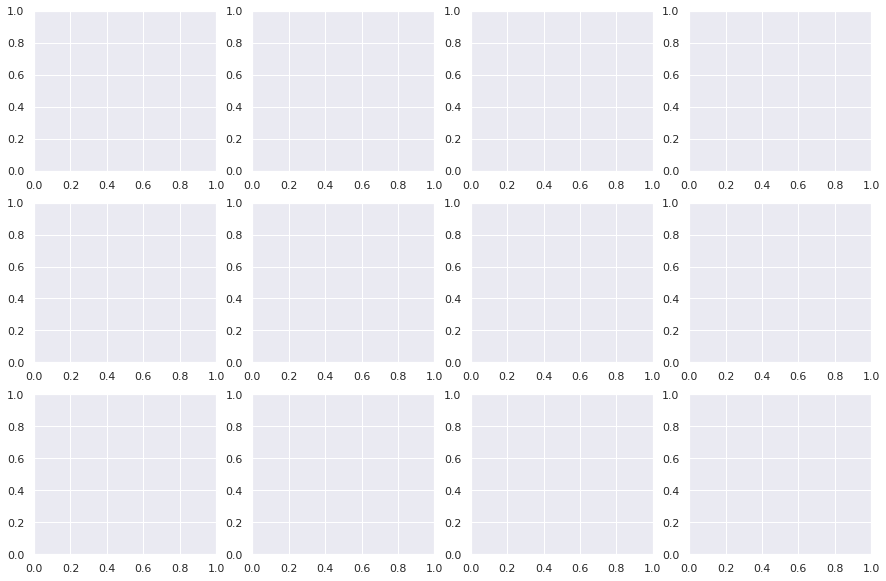

In [24]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for seq_len in range(min_length, max_length + 1):
    curr_data = mcmc_output[mcmc_output.seq_len == seq_len][['prob_diff', 'bleu_diff']]
    axes[int((seq_len - 2) / 4), (seq_len - 2) % 4].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="bleu_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 4), (seq_len - 2) % 4])
    
fig.tight_layout()